In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime
%matplotlib inline

time: 412 ms (started: 2022-11-07 20:17:30 +04:00)


In [2]:
import datetime as dt
import functools
import json
import os
import sys

import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

time: 258 ms (started: 2022-11-07 20:17:30 +04:00)


In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.0 MB/s eta 0:00:00m eta 0:00:010:00:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
time: 16.6 s (started: 2022-11-07 20:17:31 +04:00)


In [4]:
data_path = 'data/gutenberg-paragraphs.json'
with open(data_path, 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df

,text,austen
0,"\nEmma Woodhouse, handsome, clever, and rich, ...",1
1,She was the youngest of the two daughters of a...,1
2,Sixteen years had Miss Taylor been in Mr. Wood...,1
3,"The real evils, indeed, of Emma's situation we...",1
4,Sorrow came--a gentle sorrow--but not at all i...,1
...,...,...
12605,"Unseen buds, infinite, hidden well,\nUnder the...",0
12606,"Good-bye my Fancy!\nFarewell dear mate, dear l...",0
12607,Now for my last--let me look back a moment;\nT...,0
12608,"Long have we lived, joy'd, caress'd together;\...",0


time: 47.6 ms (started: 2022-11-07 20:17:47 +04:00)


In [5]:
df.isnull().sum()

text      0
austen    0
dtype: int64

time: 7.21 ms (started: 2022-11-07 20:17:47 +04:00)


In [6]:
df.rename(columns={'austen': 'target'}, inplace=True)

time: 1.73 ms (started: 2022-11-07 20:17:47 +04:00)


In [7]:
df['target'].value_counts()

0    7861
1    4749
Name: target, dtype: int64

time: 3.91 ms (started: 2022-11-07 20:17:47 +04:00)


Text(0.5, 1.0, 'distribution of text length in symbols')

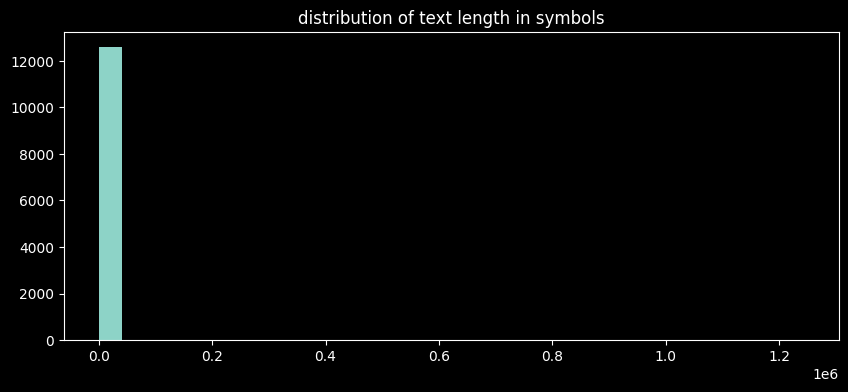

time: 299 ms (started: 2022-11-07 20:17:47 +04:00)


In [8]:
current_data = df['text'].map(lambda x: len(x))
plt.figure(figsize=(10, 4), dpi=100)
ax = plt.gca()
ax.hist(current_data, bins=30)
ax.set_title('distribution of text length in symbols')

Text(0.5, 1.0, 'distribution of text length in "words"')

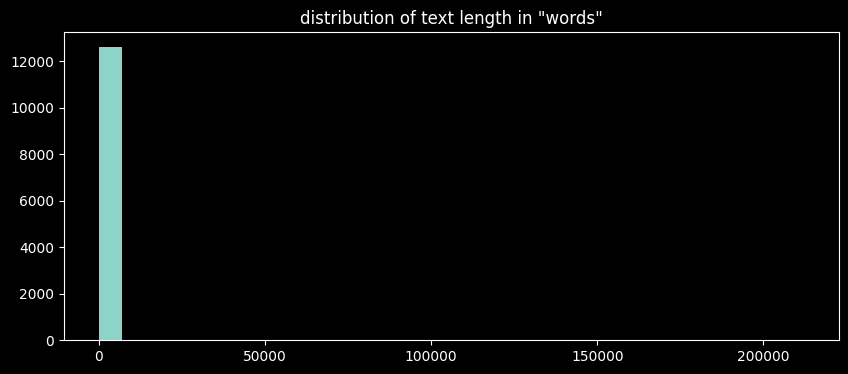

time: 284 ms (started: 2022-11-07 20:17:48 +04:00)


In [9]:
current_data = df['text'].map(lambda x: len(x.split()))
plt.figure(figsize=(10, 4), dpi=100)
ax = plt.gca()
ax.hist(current_data, bins=30)
ax.set_title('distribution of text length in "words"')

### Okay, I will choose what is the maximum acceptable length and shrink too long texts

In [10]:
df['len'] = df['text'].map(lambda x: len(x))

time: 6.34 ms (started: 2022-11-07 20:17:48 +04:00)


In [11]:
max_length = 5000
(df['len'] > max_length).sum()

11

time: 4.13 ms (started: 2022-11-07 20:17:48 +04:00)


In [12]:
df.loc[df['len'] > 100000, 'text']

4780    [Stories to Tell to Children by Sara Cone Brya...
9061    [The Parent's Assistant, by Maria Edgeworth]\r...
9062    [Moby Dick by Herman Melville 1851]\r\n\r\n\r\...
9063    [Paradise Lost by John Milton 1667] \n \n \nBo...
Name: text, dtype: object

time: 11 ms (started: 2022-11-07 20:17:48 +04:00)


### If we shrink to 5k symbols it concerns less than 0.1% of the data

In [13]:
df.loc[df['len'] > max_length, 'text'] = df.loc[df['len'] > max_length, 'text'].map(
    lambda x: x[:max_length])

time: 2.31 ms (started: 2022-11-07 20:17:48 +04:00)


Text(0.5, 1.0, 'distribution of text length in symbols')

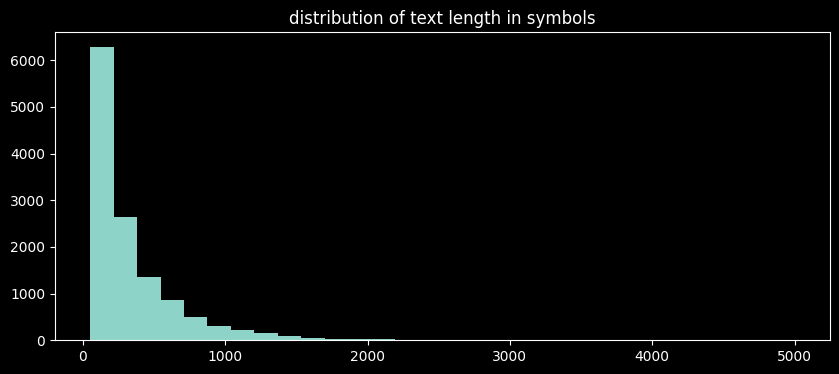

time: 212 ms (started: 2022-11-07 20:17:48 +04:00)


In [14]:
current_data = df['text'].map(lambda x: len(x))
plt.figure(figsize=(10, 4), dpi=100)
ax = plt.gca()
ax.hist(current_data, bins=30)
ax.set_title('distribution of text length in symbols')

Text(0.5, 1.0, 'distribution of text length in "words"')

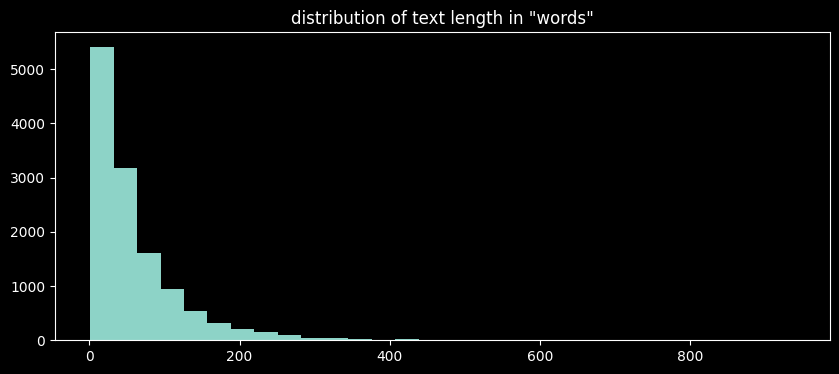

time: 283 ms (started: 2022-11-07 20:17:48 +04:00)


In [15]:
current_data = df['text'].map(lambda x: len(x.split()))
plt.figure(figsize=(10, 4), dpi=100)
ax = plt.gca()
ax.hist(current_data, bins=30)
ax.set_title('distribution of text length in "words"')

## Some cleansing

In [16]:
import spacy
from spacy.lang.en import English

time: 458 ms (started: 2022-11-07 20:17:49 +04:00)


In [17]:
def normalize_words_and_clean(s, nlp, ignore_pos=('PRON', 'DET', 'AUX')):
    doc = nlp(s)
    ignore_pos = set(ignore_pos)
    norm_words = []
    for token in doc:
        # print(token, token.lemma_, token.is_alpha, token.pos_)
        if not token.is_alpha or token.pos_ in ignore_pos:
            continue
        norm_words.append(token.lemma_.lower())
    clean_sent = ' '.join(norm_words)
    return clean_sent

time: 946 µs (started: 2022-11-07 20:17:49 +04:00)


In [18]:
# experiment with the normalization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
x = df.loc[1, 'text']
y = normalize_words_and_clean(x, nlp)
print(repr(x))
print()
print(repr(y))

/home/universe.dart.spb/smasharskiy/.local/share/virtualenvs/recruitment-ml-_SYW4Kwn/lib/python3.9/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


"She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period.  Her mother\nhad died too long ago for her to have more than an indistinct\nremembrance of her caresses; and her place had been supplied\nby an excellent woman as governess, who had fallen little short\nof a mother in affection."

'young of two daughter of most affectionate indulgent father and in consequence of sister marriage mistress of house from very early period mother die too long ago for to more than indistinct remembrance of caress and place supply by excellent woman as governess fall little short of mother in affection'
time: 470 ms (started: 2022-11-07 20:17:49 +04:00)


In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
f = functools.partial(normalize_words_and_clean, nlp=nlp)
df['clean_text'] = df['text'].progress_apply(f)
df

  0%|          | 0/12610 [00:00<?, ?it/s]

,text,target,len,clean_text
0,"\nEmma Woodhouse, handsome, clever, and rich, ...",1,240,emma woodhouse handsome clever and rich with c...
1,She was the youngest of the two daughters of a...,1,411,young of two daughter of most affectionate ind...
2,Sixteen years had Miss Taylor been in Mr. Wood...,1,597,sixteen year miss taylor in woodhouse family l...
3,"The real evils, indeed, of Emma's situation we...",1,344,real evil indeed of emma situation power of ha...
4,Sorrow came--a gentle sorrow--but not at all i...,1,551,sorrow come gentle sorrow but not at all in sh...
...,...,...,...,...
12605,"Unseen buds, infinite, hidden well,\nUnder the...",0,461,unseen bud infinite hide well under snow and i...
12606,"Good-bye my Fancy!\nFarewell dear mate, dear l...",0,162,good bye fancy farewell dear mate dear love go...
12607,Now for my last--let me look back a moment;\nT...,0,144,now for last let look back moment slow fainter...
12608,"Long have we lived, joy'd, caress'd together;\...",0,93,long live together separation good bye fancy


time: 1min 28s (started: 2022-11-07 20:17:50 +04:00)


## Let's try classic TF-IDF + SVM

In [20]:
from sklearn.model_selection import train_test_split, KFold

train, test = train_test_split(df, test_size=0.2, stratify=df['target'], random_state=1)

time: 498 ms (started: 2022-11-07 20:19:18 +04:00)


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

vectorizer = TfidfVectorizer(max_df=0.75, min_df=20)
model = SVC(random_state=1, kernel='linear')

time: 17.1 ms (started: 2022-11-07 20:19:19 +04:00)


In [22]:
corpus = train['clean_text'].tolist()
tf_idf = vectorizer.fit_transform(corpus)

time: 220 ms (started: 2022-11-07 20:19:19 +04:00)


In [23]:
print(len(vectorizer.stop_words_))

16461
time: 812 µs (started: 2022-11-07 20:19:19 +04:00)


In [24]:
tf_idf

<10088x2214 sparse matrix of type '<class 'numpy.float64'>'
	with 280311 stored elements in Compressed Sparse Row format>

time: 1.81 ms (started: 2022-11-07 20:19:19 +04:00)


In [25]:
n_folds = 5
kf = KFold(n_splits=n_folds)
results = []
for train_index, val_index in tqdm(kf.split(train), desc='Fold', total=n_folds):
    train_index = train.index[train_index]
    val_index = train.index[val_index]
    X_train = train.loc[train_index, 'clean_text'].tolist()
    X_val = train.loc[val_index, 'clean_text'].tolist()
    y_train, y_val = train.loc[train_index, 'target'], train.loc[val_index, 'target']
    
    tf_idf_train = vectorizer.fit_transform(X_train)
    tf_idf_val = vectorizer.transform(X_val)
    
    model.fit(tf_idf_train, y_train)
    train_df = train.loc[train_index].copy()
    val_df = train.loc[val_index].copy()
    train_df['pred'] = model.predict(tf_idf_train)
    val_df['pred'] = model.predict(tf_idf_val)
    results.append((train_df, val_df))

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

time: 31.5 s (started: 2022-11-07 20:19:19 +04:00)


In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score

train_f1s = [
    f1_score(train_res['target'], train_res['pred'])
    for train_res, val_res in results]
val_f1s = [
    f1_score(val_res['target'], val_res['pred'])
    for train_res, val_res in results]
train_precisions = [
    precision_score(train_res['target'], train_res['pred'])
    for train_res, val_res in results]
val_precisions = [
    precision_score(val_res['target'], val_res['pred'])
    for train_res, val_res in results]
train_recalls = [
    recall_score(train_res['target'], train_res['pred'])
    for train_res, val_res in results]
val_recalls = [
    recall_score(val_res['target'], val_res['pred'])
    for train_res, val_res in results]

print(f'Train        F1: mean: {np.mean(train_f1s):.3f}, std: {np.std(train_f1s):.5f}')
print(f'Val          F1: mean: {np.mean(val_f1s):.3f}, std: {np.std(val_f1s):.5f}', '\n')
print(f'Train precision: mean: {np.mean(train_precisions):.3f}, '
      f'std: {np.std(train_precisions):.5f}')
print(f'Val   precision: mean: {np.mean(val_precisions):.3f}, '
      f'std: {np.std(val_precisions):.5f}', '\n')
print(f'Train    recall: mean: {np.mean(train_recalls):.3f}, std: {np.std(train_recalls):.5f}')
print(f'Val      recall: mean: {np.mean(val_recalls):.3f}, std: {np.std(val_recalls):.5f}')

Train        F1: mean: 0.974, std: 0.00170
Val          F1: mean: 0.941, std: 0.00618 

Train precision: mean: 0.988, std: 0.00079
Val   precision: mean: 0.965, std: 0.00920 

Train    recall: mean: 0.961, std: 0.00279
Val      recall: mean: 0.919, std: 0.00359
time: 87 ms (started: 2022-11-07 20:19:51 +04:00)


### Wow! Just this baseline and 0.94±0.006 F1...

Let's test

In [27]:
X_train = train['clean_text'].tolist()
X_test = test['clean_text'].tolist()
y_train, y_test = train['target'], test['target']
tf_idf_train = vectorizer.fit_transform(X_train)
tf_idf_test = vectorizer.transform(X_test)

model.fit(tf_idf_train, y_train)
train_df = train.copy()
test_df = test.copy()
train_df['pred'] = model.predict(tf_idf_train)
test_df['pred'] = model.predict(tf_idf_test)

time: 8.95 s (started: 2022-11-07 20:19:51 +04:00)


In [28]:
print(f"Train        F1: {f1_score(train_df['target'], train_df['pred']):.3f}")
print(f"Test         F1: {f1_score(test_df['target'], test_df['pred']):.3f}\n")
print(f"Train precision: {precision_score(train_df['target'], train_df['pred']):.3f}")
print(f"Test  precision: {precision_score(test_df['target'], test_df['pred']):.3f}\n")
print(f"Train    recall: {recall_score(train_df['target'], train_df['pred']):.3f}")
print(f"Test     recall: {recall_score(test_df['target'], test_df['pred']):.3f}")

Train        F1: 0.977
Test         F1: 0.944

Train precision: 0.989
Test  precision: 0.970

Train    recall: 0.965
Test     recall: 0.919
time: 14 ms (started: 2022-11-07 20:20:00 +04:00)
